<a href="https://colab.research.google.com/github/Reichidad/Machine-Learning-2020-Spring-Class/blob/assignment10/assignment10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-label classification using neural networks with a regularization
## 20145822 김영현
___

## Training & Testing Code
___

In [0]:
import matplotlib.pyplot as plt
import numpy as np

# data input
file_data   = "/content/drive/My Drive/Colab Notebooks/data10/mnist.csv"
handle_file = open(file_data, "r")
data        = handle_file.readlines()
handle_file.close()

size_row    = 28    # height of the image
size_col    = 28    # width of the image

num_image   = len(data)
num_train = 1000
num_test = 9000
count       = 0     # count for the number of images

#
# normalize the values of the input data to be [0, 1]
#
def normalize(data):

    data_normalized = (data - min(data)) / (max(data) - min(data))

    return(data_normalized)

#
# make a matrix each column of which represents an images in a vector form
#
list_image_train  = np.empty((size_row * size_col, num_train), dtype=float)
list_label_train  = np.empty(num_train, dtype=int)
list_image_test = np.empty((size_row * size_col, num_test), dtype=float)
list_label_test  = np.empty(num_test, dtype=int)

# list for store all iterations
train_loss_list = []
train_accr_list = []
test_loss_list = []
test_accr_list = []

# matrix initialization
for line in data:

    line_data   = line.split(',')
    label       = line_data[0]
    im_vector   = np.asfarray(line_data[1:])
    im_vector   = normalize(im_vector)

    if count < num_train:
      list_label_train[count]       = label
      list_image_train[:, count]    = im_vector
    else:
      list_label_test[count - num_train] = label
      list_image_test[:, count - num_train] = im_vector
    count += 1

# theta initialization with normal distribution N(0, 1)
theta_u = np.random.randn(196, 785)
theta_v = np.random.randn(49, 197)
theta_w = np.random.randn(10,50)
# learning values
alpha = 0.6
lambda_reg = 7.5

# one_hot_encoding of labels for calculation
one_hot_label_train = np.zeros((10, num_train), dtype=float)
for i in range(num_train):
  one_hot_label_train[list_label_train[i],i] = 1
one_hot_label_test = np.zeros((10, num_test), dtype=float)
for i in range(num_test):
  one_hot_label_test[list_label_test[i],i] = 1

# fully connected calculation with bias(1)
def func_calc(theta_list, op_list):
  return np.matmul(theta_list, np.insert(op_list, 0, 1))


# sigmoid calculation
def sigmoid(val):
  return 1/(1+np.exp(-val))


# derivative of the sigmoid
def d_sigmoid(val):
  sig_now = sigmoid(val)
  return sig_now * (1 - sig_now)


# objective function
def ob_func(labels, results, num):
  sum = 0
  for i in range(num):
    for j in range(len(results)):
      sum += (-labels[j,i] * np.log(results[j][i])) - ((1 - labels[j,i]) * np.log(1 - results[j][i]))
  return sum/num + ob_func_reg()


# addition loss with regularization
def ob_func_reg():
  avg_u = np.mean(theta_u**2)
  avg_v = np.mean(theta_v**2)
  avg_w = np.mean(theta_w**2)
  size = theta_u.size + theta_v.size + theta_w.size
  return lambda_reg * (avg_u + avg_v + avg_w) / (2 * size) 


# addition gradient decent with regularization
def g_d_reg(theta):
  return lambda_reg * theta / theta.size
# main function for 1 iteration
def train_once():
  global theta_u, theta_v, theta_w
  # --------------------------
  # training code
  # --------------------------
  # data storage for training
  result_set = np.empty((10, num_train))
  accr = 0
  theta_u_next = np.zeros((196, 785))
  theta_v_next = np.zeros((49, 197))
  theta_w_next = np.zeros((10, 50))
  
  # training 
  for num in range(num_train):
    # forward-propagation
    x = list_image_train[:, num]
    y = func_calc(theta_u, x)
    y_sigmoid = sigmoid(y)
    z= func_calc(theta_v, y_sigmoid)
    z_sigmoid = sigmoid(z)
    h = func_calc(theta_w, z_sigmoid)
    h_sigmoid = sigmoid(h)
    result_set[:, num] = h_sigmoid

    # accuracy count
    if np.argmax(h_sigmoid) == list_label_train[num]:
      accr += 1

    # gradient descent with back-propagation
    d_first = np.zeros(10)
    for i in range(10):
      d_first[i] = (1-one_hot_label_train[i,num])/(1-h_sigmoid[i]) - one_hot_label_train[i,num]/h_sigmoid[i]
      d_first[i] *= d_sigmoid(h[i])
    theta_w_next += np.matmul(d_first.reshape(10,1), np.insert(z_sigmoid, 0, 1).reshape(1,50))
    
    d_second = np.matmul(d_first, theta_w)
    for i in range(1,50):
      d_second[i] *= d_sigmoid(z[i-1])
    theta_v_next += np.matmul(d_second[1:].reshape(49, 1), np.insert(y_sigmoid, 0, 1).reshape(1, 197))

    d_third = np.matmul(d_second[1:50], theta_v)
    for i in range(1,197):
      d_third[i] *= d_sigmoid(y[i-1])
    theta_u_next += np.matmul(d_third[1:].reshape(196,1), np.insert(x, 0, 1).reshape(1, 785))

  # store train_loss & train_accuracy after training done
  train_loss = ob_func(one_hot_label_train, result_set, num_train)
  train_loss_list.append(train_loss)
  accr = accr * 100 / num_train
  train_accr_list.append(accr)

  # --------------------------
  # testing code
  # --------------------------
  # data storage for testing
  test_result_set = np.empty((10, num_test))
  test_accr = 0

  # testing
  for num in range(num_test):
    # forward-propagation only in testing
    x = list_image_test[:, num]
    y = func_calc(theta_u, x)
    y_sigmoid = sigmoid(y)
    z= func_calc(theta_v, y_sigmoid)
    z_sigmoid = sigmoid(z)
    h = func_calc(theta_w, z_sigmoid)
    h_sigmoid = sigmoid(h)
    test_result_set[:, num] = h_sigmoid

    # accuracy count
    if np.argmax(h_sigmoid) == list_label_test[num]:
      test_accr += 1
  # store test_loss & test_accuracy after testing done
  test_loss = ob_func(one_hot_label_test, test_result_set, num_test)
  test_loss_list.append(test_loss)
  test_accr = test_accr * 100 / num_test
  test_accr_list.append(test_accr)

  # update theta
  theta_u -= (alpha * (theta_u_next/num_train + g_d_reg(theta_u)))
  theta_v -= (alpha * (theta_v_next/num_train + g_d_reg(theta_v)))
  theta_w -= (alpha * (theta_w_next/num_train + g_d_reg(theta_w)))

  return result_set, test_result_set
# start iteration
iteration = 0
escape_flag = 0
while iteration < 3500:
  result_set, test_result_set = train_once()
  print(iteration)
  print("train / test loss :", train_loss_list[-1], test_loss_list[-1])
  print("train / test accr :", train_accr_list[-1], test_accr_list[-1])
  iteration += 1



In [24]:
print("iteration finished with\n",
      "iteration :", iteration,"\n",
      "alpha / lambda :", alpha, lambda_reg, "\n",
      "train_loss :", train_loss_list[-1],"\n",
      "train_accr :", train_accr_list[-1], "%\n",
      "test_loss :", test_loss_list[-1], "\n",
      "test_accr :", test_accr_list[-1], "%")

iteration finished with
 iteration : 3500 
 alpha / lambda : 0.6 7.5 
 train_loss : 0.41769111143168347 
 train_accr : 100.0 %
 test_loss : 0.9663336306762892 
 test_accr : 86.68888888888888 %


## Submission
___

### 1. Plot the loss curve
___

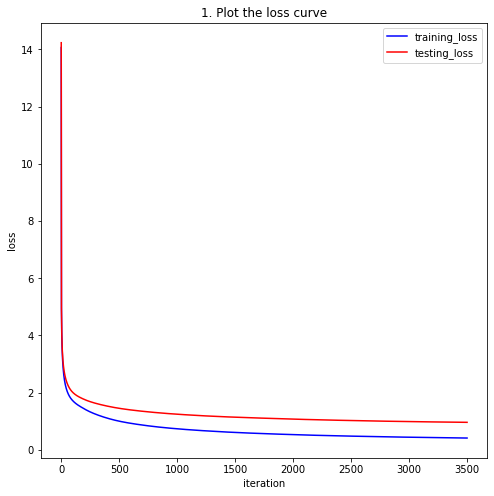

In [0]:
plt.figure(figsize=(8,8))
plt.title("1. Plot the loss curve")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.plot([i for i in range(iteration)], train_loss_list, label="training_loss", c='b')
plt.plot([i for i in range(iteration)], test_loss_list, label="testing_loss", c='r')
plt.legend()
plt.show()

### 2. Plot the accuracy curve
___

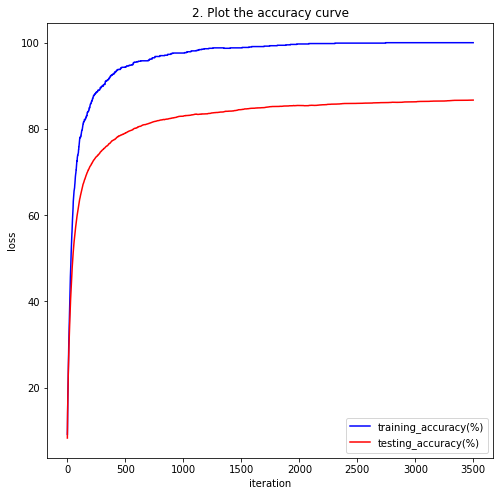

In [29]:
plt.figure(figsize=(8,8))
plt.title("2. Plot the accuracy curve")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.plot([i for i in range(iteration)], train_accr_list, label="training_accuracy(%)", c='b')
plt.plot([i for i in range(iteration)], test_accr_list, label="testing_accuracy(%)", c='r')
plt.legend()
plt.show()

### 3. Plot the accuracy value
___

In [30]:
print("3. Plot the accuracy value")
print("The final training accuracy(%) =", train_accr_list[-1], "%")
print("The final testing accuracy(%) =", test_accr_list[-1], "%")

3. Plot the accuracy value
The final training accuracy(%) = 100.0 %
The final testing accuracy(%) = 86.68888888888888 %


### 4. Plot the classification example
___

4. Plot the classification example


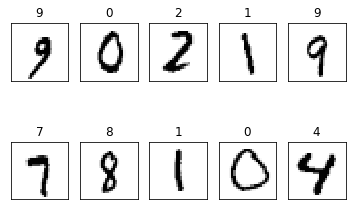

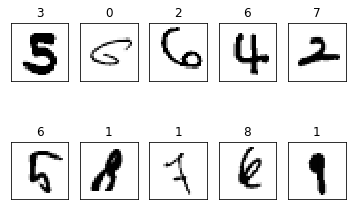

In [31]:
print("4. Plot the classification example")
f1 = plt.figure(1)

count = 0
for i in range(num_test):
  if list_label_test[i] == np.argmax(test_result_set[:, i]):
    label       = np.argmax(test_result_set[:, i])
    im_vector   = list_image_test[:, i]
    im_matrix   = im_vector.reshape((size_row, size_col))

    count += 1
    plt.subplot(2, 5, count)
    plt.title(label)
    plt.imshow(im_matrix, cmap='Greys', interpolation='None')

    frame   = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)


  if count == 10:
    break

f2 = plt.figure(2)

count = 0
for i in range(num_test):
  if list_label_test[i] != np.argmax(test_result_set[:, i]):
    label       = np.argmax(test_result_set[:, i])
    im_vector   = list_image_test[:, i]
    im_matrix   = im_vector.reshape((size_row, size_col))

    count += 1
    plt.subplot(2, 5, count)
    plt.title(label)
    plt.imshow(im_matrix, cmap='Greys', interpolation='None')

    frame   = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)

    
  if count == 10:
    break

plt.show()